# Zeeman-Aufspaltung

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.signal import find_peaks
import scipy.constants as constants
from scipy.stats import linregress

Umrechnung des CCD-Monitor-Fensters in Wellenlänge:

In [2]:
cali = np.loadtxt('data/kalibration_585_588.dat').T

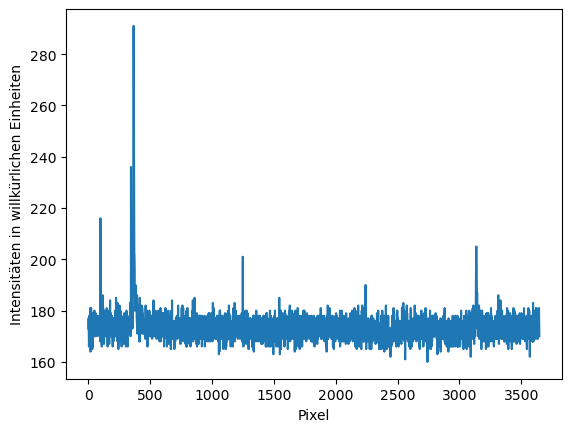

In [3]:
ax = plt.subplots()
plt.plot(cali[0],cali[1])
plt.ylabel('Intensitäten in willkürlichen Einheiten')
plt.xlabel('Pixel')
plt.savefig('plots/cali_585_588.pdf')

In [4]:
peaks = find_peaks(cali[1],height=200)[0]
print(peaks)
# dritter Peak und fünfter Peak sind 585 nm und 588 nm
print(peaks[4]-peaks[2])

def pix_to_nm(pixel):
    '''Umrechnung einer Pixeldifferenz in nm'''
    return pixel*3/2771.0

[  97  344  365 1248 3136]
2771


Normaler Zeeman-Effekt anhand der 585.2 nm-Linie:

In [5]:
label_pi = ['5_pi','10_pi','15_pi','20_pi','25_pi']
label_sigma = ['5_sigma','10_sigma','15_sigma','20_sigma','25_sigma']
h_feld = ['5 kOerstedt','10 kOerstedt','15 kOerstedt','20 kOerstedt','25 kOerstedt']
pi = {}
sigma = {}

for i in range(len(label_pi)):
    pi[label_pi[i]] = np.loadtxt('data/normal/normal_' + label_pi[i] + '.dat').T
    sigma[label_sigma[i]] = np.loadtxt('data/normal/normal_' + label_sigma[i] + '.dat').T

Wellenlängen-Umrechnung noch notwendig!!!

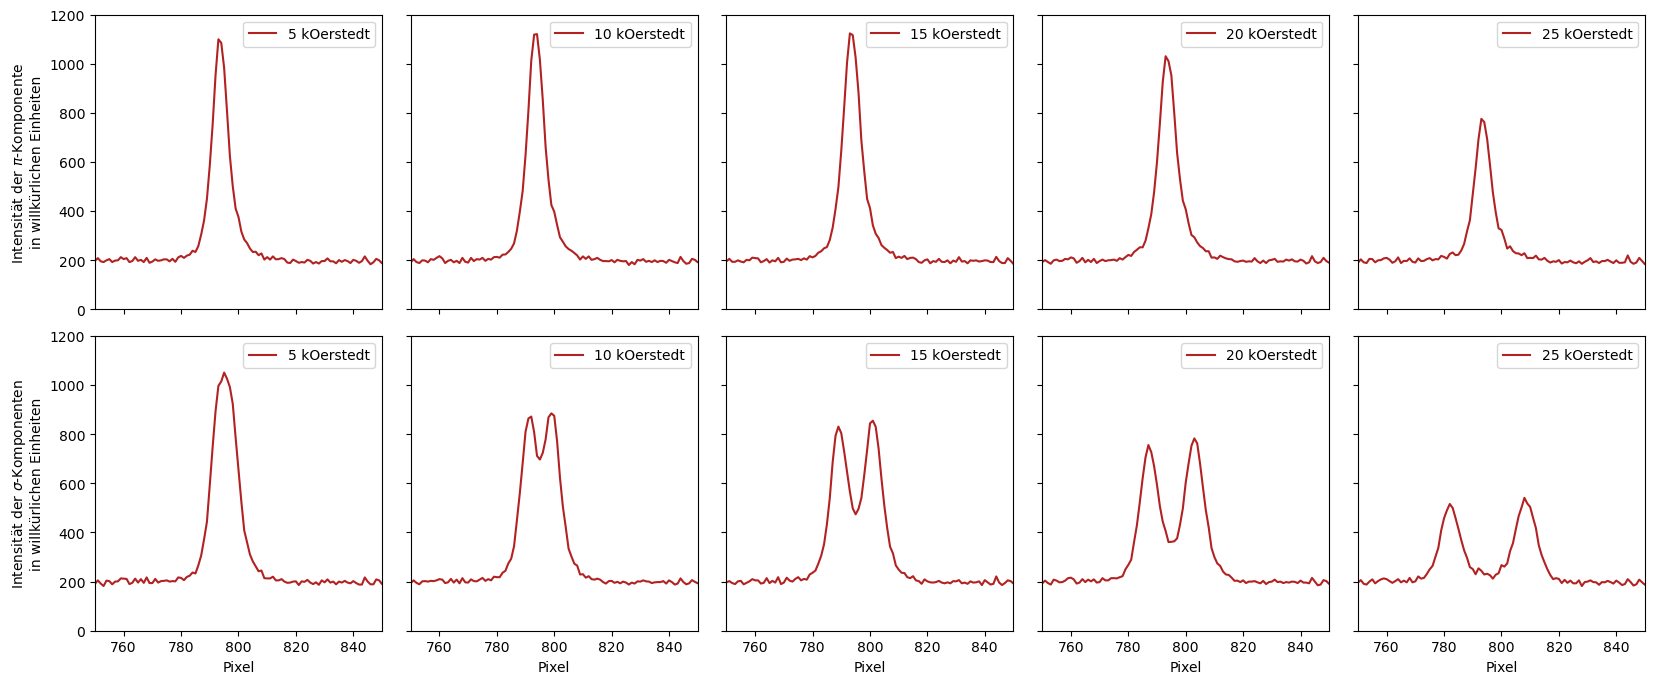

In [6]:
fig, (axes1,axes2) = plt.subplots(2,5,figsize=(20,8),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.09,wspace=0.1)

x1,x2 = 750,850
y1,y2 = 0,1200

for i in range(len(label_pi)):
    axes1[i].plot(pi[label_pi[i]][0],pi[label_pi[i]][1],c='firebrick',label=h_feld[i])
    axes2[i].plot(sigma[label_sigma[i]][0],sigma[label_sigma[i]][1],c='firebrick',label=h_feld[i])

    axes1[i].set_xlim(x1,x2)
    axes2[i].set_xlim(x1,x2)
    axes1[i].set_ylim(y1,y2)
    axes2[i].set_ylim(y1,y2)
    axes2[i].set_xlabel('Pixel')
    axes1[i].legend()
    axes2[i].legend()

axes1[0].set_ylabel('Intensität der $\pi$-Komponente\nin willkürlichen Einheiten')
axes2[0].set_ylabel('Intensität der $\sigma$-Komponenten\nin willkürlichen Einheiten')

plt.savefig("plots_2/normaler_zeeman.pdf")

Integirere über Pi- und Sigma-Komponenten in den oberen Plots, um Intensitätsregeln zu prüfen. Ziehe Untergrund nicht ab, da ich ihn als konstant annehme. Nutze scipy.integrate.trapezoid() zum Integrieren. Ziehe Untergrund von 200 ab. 

In [7]:
sum_pi = []
sum_sigma = []

for i in range(len(label_pi)):
    # y steht vor x bei Funktionsaufruf
    sum_pi.append(trapezoid(pi[label_pi[i]][1][750:850]-200,pi[label_pi[i]][0][750:850]))
    sum_sigma.append(trapezoid(sigma[label_sigma[i]][1][750:850]-200,sigma[label_sigma[i]][0][750:850]))

sum_pi = np.array(sum_pi)
sum_sigma = np.array(sum_sigma)
verhältnis = sum_pi/sum_sigma
print(sum_pi)
print(sum_sigma)
print(verhältnis)
print(np.mean(verhältnis))
print(np.std(verhältnis))

[7095.  7661.  8042.  7415.  4670.5]
[ 9280.  10263.5 10763.5 10291.5  6168.5]
[0.76454741 0.74643153 0.74715474 0.7204975  0.75715328]
0.7471568911203468
0.014923856365742404


Integriere über Sigma-Komponenten. Nutze Pi-Peak als Grenze der Integrationsbereiche, welchen ich mit find_peaks bestimme.

In [8]:
peaks_pi = []
sum_sigma_minus = []
sum_sigma_plus = []
height_sigma = []

for i in range(1,len(label_pi)):
    #Rückgabe ist Liste mit einem Wert (da nur ein Peak)
    delimiter = find_peaks(pi[label_pi[i]][1][750:850],height=500)[0][0] + 750
    peaks_pi.append(delimiter)
    sum_sigma_minus.append(trapezoid(sigma[label_sigma[i]][1][750:delimiter]-200,sigma[label_sigma[i]][0][750:delimiter]))
    sum_sigma_plus.append(trapezoid(sigma[label_sigma[i]][1][delimiter:850]-200,sigma[label_sigma[i]][0][delimiter:850]))

    height_sigma.append(find_peaks(sigma[label_sigma[i]][1][750:850],height=500)[1]['peak_heights'])

sum_sigma_minus = np.array(sum_sigma_minus)
sum_sigma_plus = np.array(sum_sigma_plus)
verhältnis = sum_sigma_minus/sum_sigma_plus

height_verhältnis = []

for i in range(len(height_sigma)):
    height_verhältnis.append(height_sigma[i][0]/height_sigma[i][1])
height_verhältnis = np.array(height_verhältnis)

print(peaks_pi)
print(sum_sigma_minus)
print(sum_sigma_plus)
print(verhältnis)
print(np.mean(verhältnis))
print(np.std(verhältnis))
print(height_sigma)
print(height_verhältnis)
print(np.mean(height_verhältnis))
print(np.std(height_verhältnis))

[794, 793, 793, 793]
[3864.  4147.5 4367.5 2876. ]
[5839.5 6209.  5699.  3243.5]
[0.66170049 0.66798196 0.76636252 0.88669647]
0.7456853598317844
0.09138237640193381
[array([872., 885.]), array([831., 855.]), array([756., 783.]), array([516., 541.])]
[0.98531073 0.97192982 0.96551724 0.95378928]
0.9691367698791863
0.011380298153084641


Bestimmung des Verhältnis e/m über die Wellenlängenaufspaltung bei 10 bis 25 kOerstedt, Nutze Aufspaltung zwischen M_J=1 und M_J=-1:

In [9]:
def slope_si(slope,lam_0,M_J1,g_J1,M_J2,g_J2):
    return slope*1e-12*4*constants.pi*constants.c**2*np.sqrt(constants.epsilon_0)/(lam_0**2*79.5775*np.sqrt(constants.mu_0)*(M_J2*g_J2-M_J1*g_J1))

[array([44], dtype=int64), array([43], dtype=int64), array([43], dtype=int64), array([43], dtype=int64)]
[array([42, 49], dtype=int64), array([39, 51], dtype=int64), array([37, 53], dtype=int64), array([32, 58], dtype=int64)]
[0.00757849 0.0129917  0.01732227 0.02814868]
slope:  0.0013208228076506676
stderr:  0.0002019641801462752
Calculated charge to mass:  70261238636.71729
error:  10743495172.19985
Real charge to mass:  -175882001076.0
Calculated/Real:  -0.3994794135094975


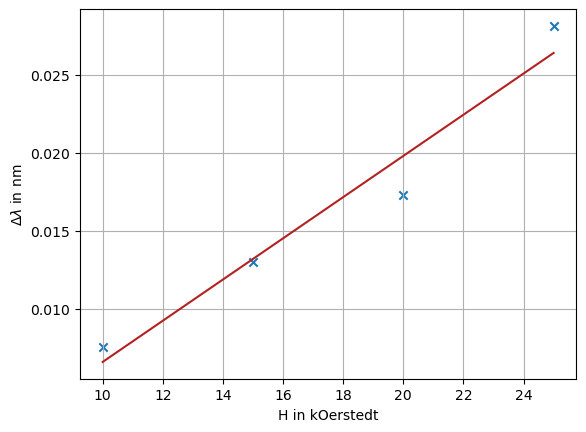

In [10]:
pi_peaks = []
sigma_peaks = []
H = np.array([10.0,15.0,20.0,25.0])

for i in range(1,len(label_pi)):
    pi_peaks.append(find_peaks(pi[label_pi[i]][1][750:850],height=500)[0])
    sigma_peaks.append(find_peaks(sigma[label_sigma[i]][1][750:850],height=500)[0])

print(pi_peaks)
print(sigma_peaks)

diff_lam = []
for j in sigma_peaks:
    difference = j[1] - j[0]
    diff_lam.append(pix_to_nm(difference))

diff_lam = np.array(diff_lam)
print(diff_lam)

ax = plt.subplots()
plt.scatter(H,diff_lam,marker='x')

slope, intercept, rvalue, pvalue, stderr = linregress(H,diff_lam)

em = slope_si(slope,585.2e-9,-1,1.034,1,1.034)
error_em = slope_si(stderr,585.2e-9,-1,1.034,1,1.034)

print('slope: ',slope)
print('stderr: ',stderr)
print('Calculated charge to mass: ',em)
print('error: ', error_em)
real_em = constants.physical_constants['electron charge to mass quotient'][0]
print('Real charge to mass: ',real_em)
print('Calculated/Real: ',em/real_em)


x_values = np.linspace(10,25,1000)
y_values = slope*x_values+intercept
plt.plot(x_values,y_values,color='firebrick')

plt.xlabel('H in kOerstedt')
plt.ylabel('$\Delta\lambda$ in nm')
plt.grid()
plt.savefig('plots/aufspaltung_gerade.pdf')

Anomaler Zeeman-Effekt:

In [11]:
label_pi = ['5_pi','10_pi','15_pi','20_pi','25_pi']
label_sigma = ['5_sigma','10_sigma','15_sigma','20_sigma','25_sigma']
h_feld = ['5 kOerstedt','10 kOerstedt','15 kOerstedt','20 kOerstedt','25 kOerstedt']
pi = {}
sigma = {}

for i in range(len(label_pi)):
    pi[label_pi[i]] = np.loadtxt('data/anomal/' + label_pi[i] + '.dat').T
    sigma[label_sigma[i]] = np.loadtxt('data/anomal/' + label_sigma[i] + '.dat').T

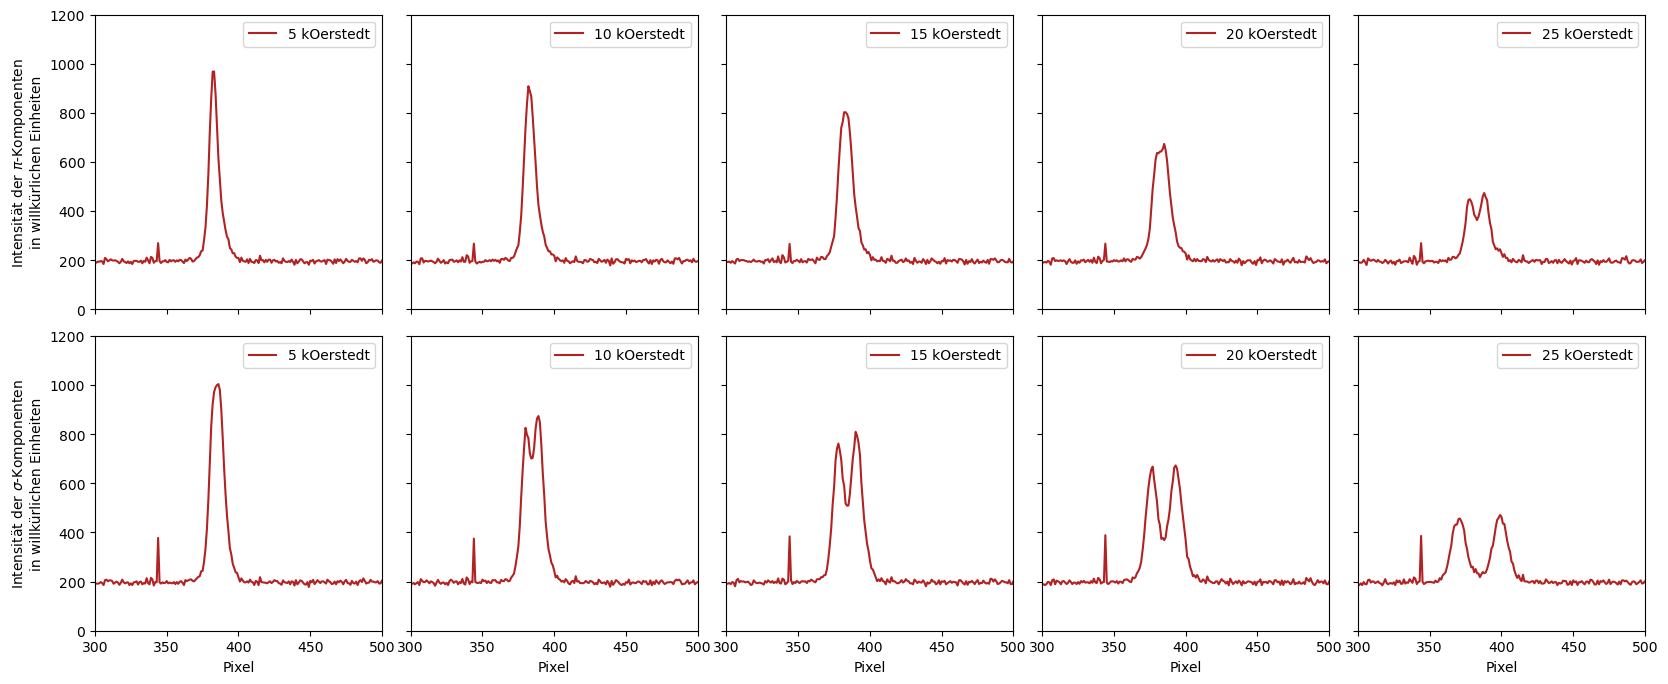

In [12]:
fig, (axes1,axes2) = plt.subplots(2,5,figsize=(20,8),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.09,wspace=0.1)

x1,x2 = 300,500  #0,3648
y1,y2 = 0,1200

for i in range(len(label_pi)):
    axes1[i].plot(pi[label_pi[i]][0],pi[label_pi[i]][1],c='firebrick',label=h_feld[i])
    axes2[i].plot(sigma[label_sigma[i]][0],sigma[label_sigma[i]][1],c='firebrick',label=h_feld[i])

    axes1[i].set_xlim(x1,x2)
    axes2[i].set_xlim(x1,x2)
    axes1[i].set_ylim(y1,y2)
    axes2[i].set_ylim(y1,y2)
    axes2[i].set_xlabel('Pixel')
    axes1[i].legend()
    axes2[i].legend()

axes1[0].set_ylabel('Intensität der $\pi$-Komponenten\nin willkürlichen Einheiten')
axes2[0].set_ylabel('Intensität der $\sigma$-Komponenten\nin willkürlichen Einheiten')

plt.savefig('plots/anomaler_zeeman_plot.pdf')

Thorlabs-Spektrum wird zum Vergleich herangezogen. Abstand der Wellenlängen in nm und Höhen der Peaks sprechen für 614 und 616 nm-Linien:

[ 383 2444]
2.231324431613136


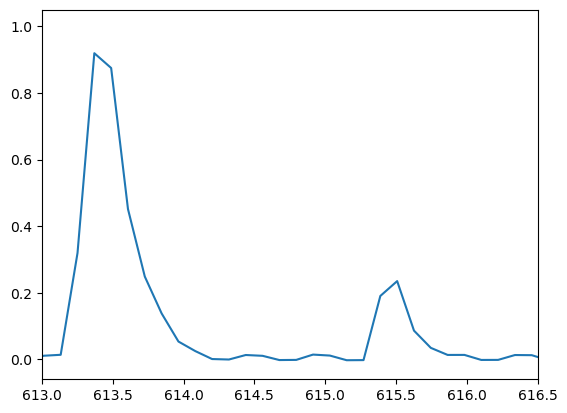

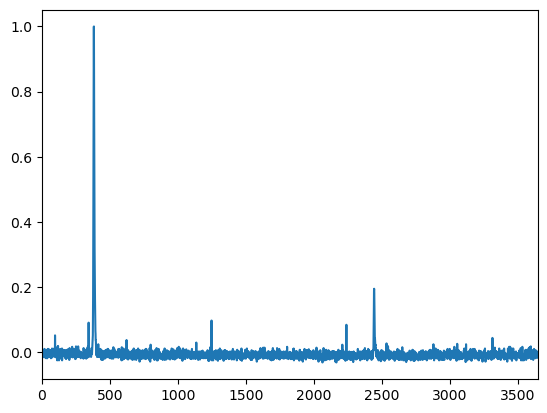

In [13]:
thorlabs1 = np.loadtxt('data/thorlabs_fokus.txt').T
thorlabs2 = np.loadtxt('data/thorlabs_nichtsat.txt').T

x1,x2 = 613,616.5

# ax = plt.subplots()
# plt.plot(thorlabs1[0],thorlabs1[1])
# plt.xlim(x1,x2)

ax = plt.subplots()
norm1 = np.max(thorlabs2[1])
plt.plot(thorlabs2[0],thorlabs2[1]/norm1)
plt.xlim(x1,x2)

u1,u2 = 0,3648 #300,500

ax = plt.subplots()
norm2 = np.max(pi['5_pi'][1]-200)
plt.plot(pi['5_pi'][0],(pi['5_pi'][1]-200)/norm2)
plt.xlim(u1,u2)

linien = find_peaks((pi['5_pi'][1]-200)/norm2,height=0.19)[0]
print(linien)
print(pix_to_nm(linien[1]-linien[0]))